# Imports and Data Download :

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(torch.__version__)

mnist_trainset = torchvision.datasets.MNIST(
                              root='./data', 
                              train=True, 
                              download=True, 
                              transform=transforms.Compose([
                                  transforms.ToTensor()
                              ])
                  )

1.9.0+cu111


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data Preparation :
* This code contains logic to create the 

In [2]:
def create_one_hotencoding_inp(x: int):
  """
  This function allows user to convert the input number (between 0 to 9) 
  in to one hot encoded vector of size 10.
  input : x = number between 0-9
  output : base_arr = one hot encoded vector with 10 list elements
  """
  assert isinstance(x, int) or isinstance(x, np.int64) or isinstance(x, np.int32), "input should be of datatype 'int'"
  assert x>=0 and x<=9, "input should be between 0-9"
  base_arr = np.zeros(10)
  base_arr[x] = 1
  return base_arr

# create_one_hotencoding_inp("2")  # Error checking for string input
# create_one_hotencoding_inp(10) # Error checking for number not in range 0-9

In [3]:
def extract_images_and_labels(num_obs: int, mnist_trainset):
  i=0
  i_max=int(num_obs)
  lst_imgs = []
  lst_labels = []
  for img, label in mnist_trainset:
    lst_imgs.append(img)
    lst_labels.append(label)
    i += 1
    if i==i_max:
      break;

  # Checking class distribution
  df_class_distro = pd.DataFrame(pd.Series(lst_labels).value_counts().sort_index(), columns=['count_labels']).reset_index()
  df_class_distro.rename({'index':'class_label'}, axis=1, inplace=True)
  print(f"Printing class distibution below : \n{df_class_distro}")
  return(lst_imgs, lst_labels)

lst_imgs, lst_labels = extract_images_and_labels(30000, mnist_trainset)
print(len(lst_imgs))
print(len(lst_labels))

Printing class distibution below : 
   class_label  count_labels
0            0          2961
1            1          3423
2            2          2948
3            3          3073
4            4          2926
5            5          2709
6            6          2975
7            7          3107
8            8          2875
9            9          3003
30000
30000


In [4]:
def prepare_my_dataset(lst_imgs: list, lst_labels: list):
  """
  This function will prepare the dataset as per the below requirement :
  Creates the tensor of input images
  Creates the random input numbers same as size of input images & creates the one hot encoded vectors of each obs
  Creates the tensor of output image labels
  Creates the target sum which is sum of input random number and image label
  """
  inp_images = torch.stack(lst_imgs)
  out_img_labels = torch.tensor(lst_labels)

  i = 0
  while i!=10:
    inp_rand_np = np.random.randint(0,10,len(out_img_labels))
    i = pd.Series(inp_rand_np).nunique()
    print(f"Number of unique values in my random set '{i}'")

  inp_rand = torch.tensor(inp_rand_np)
  out_sum = inp_rand + out_img_labels

  inp_rand_ohe = torch.tensor([create_one_hotencoding_inp(x) for x in inp_rand_np])
  return(inp_images, inp_rand_ohe, out_img_labels, out_sum)

inp_images, inp_rand_ohe, out_img_labels, out_sum = prepare_my_dataset(lst_imgs, lst_labels)
print(inp_images.shape)
print(inp_rand_ohe.shape)
print(out_img_labels.shape)
print(out_sum.shape)

Number of unique values in my random set '10'
torch.Size([30000, 1, 28, 28])
torch.Size([30000, 10])
torch.Size([30000])
torch.Size([30000])


In [5]:
# Assigning all the input tensors to cuda
print("device before allocating to cuda : ",inp_images.device, inp_rand_ohe.device, out_img_labels.device, out_sum.device)
inp_images, inp_rand_ohe, out_img_labels, out_sum = inp_images.cuda(), inp_rand_ohe.cuda(), out_img_labels.cuda(), out_sum.cuda()
print("device after allocating to cuda : ",inp_images.device, inp_rand_ohe.device, out_img_labels.device, out_sum.device)

device before allocating to cuda :  cpu cpu cpu cpu
device after allocating to cuda :  cuda:0 cuda:0 cuda:0 cuda:0


In [6]:
from torch.utils.data import Dataset

# Creating the Custom dataset using previously created data so that we can use this dataset object to create batches later
class CustomMnistDataset(Dataset):
  def __init__(self):
    self.data = []
    for i in range(0,len(out_sum)):
      self.data.append([inp_images[i], inp_rand_ohe[i], out_img_labels[i], out_sum[i]])

  def __getitem__(self, index):
    return self.data[index]
    
  def __len__(self):
    return len(self.data)

myDataset = CustomMnistDataset()
len(myDataset)

30000

In [7]:
# creating train_loader so that we can load data in batches while training
train_loader = torch.utils.data.DataLoader(myDataset
    ,batch_size=32
    ,shuffle=True
)

len(train_loader)

938

In [8]:
# Printing the size of first 3 batches
i=0
for tr in train_loader:
  print(tr[0].shape, tr[1].shape, tr[2].shape, tr[3].shape)
  i+=1
  if i==3:
    break;

torch.Size([32, 1, 28, 28]) torch.Size([32, 10]) torch.Size([32]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32, 10]) torch.Size([32]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32, 10]) torch.Size([32]) torch.Size([32])


# Model Building :

In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [10]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    #28 - > 24 - > 12 -> 8 -> 4
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.fc1 = nn.Linear(in_features=(12 * 4 * 4)+10, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out1 = nn.Linear(in_features=60, out_features=10)
    self.out2 = nn.Linear(in_features=60, out_features=19)
  
  def forward(self, t1, t2):
    # input layer
    x, y = t1, t2

    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshapre
    x = x.reshape(-1, 12 * 4 * 4)
    z = torch.cat((x,y.reshape(-1,10)), dim=1)
    
    # fc1 layer
    z = self.fc1(z)
    z = F.relu(z)

    # fc2 layer
    z = self.fc2(z)
    z = F.relu(z)

    # output layer 1
    o1 = self.out1(z)
    o1 = F.softmax(o1, dim=1)

    # output layer 2
    o2 = self.out2(z)
    o2 = F.softmax(o2, dim=1)
    return o1, o2

In [11]:
network = Network()

print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=202, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out1): Linear(in_features=60, out_features=10, bias=True)
  (out2): Linear(in_features=60, out_features=19, bias=True)
)


In [12]:
# Assigning my network parameters to cuda as well
network = network.cuda()

In [13]:
import torch.optim as optim

torch.set_grad_enabled(True)

In [14]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [15]:
optimizer = optim.Adam(network.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):

    total_loss = 0
    total_correct_labels = 0
    total_correct_sum = 0

    for batch in train_loader: # Get Batch
        i_images, i_rand, o_labels, o_sum = batch 

        preds_labels, preds_sum = network(i_images, i_rand.float()) # Pass Batch
        loss1 = F.cross_entropy(preds_labels, o_labels) # Calculate Loss
        loss2 = F.cross_entropy(preds_sum, o_sum) # Calculate Loss
        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct_labels += get_num_correct(preds_labels, o_labels)
        total_correct_sum += get_num_correct(preds_sum, o_sum)

    print(
        "epoch", epoch, 
        " | total_correct_labels:", total_correct_labels,
        "/",round((total_correct_labels/len(inp_rand_ohe))*100,2),"%",
        " | total_correct_sum:", total_correct_sum, 
        "/",round((total_correct_sum/len(inp_rand_ohe))*100,2),"%",
        " | loss:", total_loss
    )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0  | total_correct_labels: 22683 / 75.61 %  | total_correct_sum: 2933 / 9.78 %  | loss: 4343.642276287079
epoch 1  | total_correct_labels: 28595 / 95.32 %  | total_correct_sum: 3527 / 11.76 %  | loss: 4138.888205051422
epoch 2  | total_correct_labels: 28922 / 96.41 %  | total_correct_sum: 6319 / 21.06 %  | loss: 4059.9134788513184
epoch 3  | total_correct_labels: 29047 / 96.82 %  | total_correct_sum: 11405 / 38.02 %  | loss: 3906.726266145706
epoch 4  | total_correct_labels: 29234 / 97.45 %  | total_correct_sum: 13261 / 44.2 %  | loss: 3830.9711167812347
epoch 5  | total_correct_labels: 29347 / 97.82 %  | total_correct_sum: 13721 / 45.74 %  | loss: 3808.318681716919
epoch 6  | total_correct_labels: 29407 / 98.02 %  | total_correct_sum: 13942 / 46.47 %  | loss: 3796.4209303855896
epoch 7  | total_correct_labels: 29512 / 98.37 %  | total_correct_sum: 13995 / 46.65 %  | loss: 3790.6346876621246
epoch 8  | total_correct_labels: 29566 / 98.55 %  | total_correct_sum: 14288 / 47.63 %  |

# Inference :

In [16]:
import matplotlib.pyplot as plt

Index is : '9543'
Input Number is : '5'
Shape of my inp rand number : torch.Size([1, 10])
Shape of my input image : torch.Size([1, 1, 28, 28])


--------------------------------------------------------------------------------------------


Actual image label is : 8
Actual input random number is : 5
Predicted image label is : 8
Predicted sum label is : 13


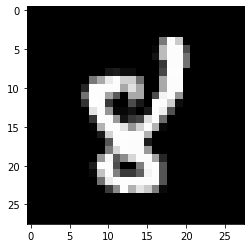

In [17]:
random_index = np.random.randint(100,inp_images.shape[0], 1)[0]
print(f"Index is : '{random_index}'")
inp_rnd_num_inf = np.random.randint(0,9,1)[0]
print(f"Input Number is : '{inp_rnd_num_inf}'")

inp_rnd_num_inf_ohe = create_one_hotencoding_inp(inp_rnd_num_inf).reshape(1,10)
inp_rnd_num_inf_ohe = torch.tensor(inp_rnd_num_inf_ohe).cuda()
print(f"Shape of my inp rand number : {inp_rnd_num_inf_ohe.shape}")
inp_img_inf = inp_images[random_index].reshape(1,1,28,28)
print(f"Shape of my input image : {inp_img_inf.shape}")

print("\n\n--------------------------------------------------------------------------------------------\n\n")

image = inp_img_inf.cpu().detach()
label = out_img_labels[random_index]
plt.imshow(image.squeeze(), cmap='gray')
print('Actual image label is :', label.cpu().detach().numpy())

pred_img_label, pred_sum_label = network(inp_img_inf, inp_rnd_num_inf_ohe.float())
print(f"Actual input random number is : {inp_rnd_num_inf}")
print(f"Predicted image label is : {pred_img_label.argmax().cpu().detach().numpy()}")
print(f"Predicted sum label is : {pred_sum_label.argmax().cpu().detach().numpy()}")

Index is : '10394'
Input Number is : '5'
Shape of my inp rand number : torch.Size([1, 10])
Shape of my input image : torch.Size([1, 1, 28, 28])


--------------------------------------------------------------------------------------------


Actual image label is : 7
Actual input random number is : 5
Predicted image label is : 7
Predicted sum label is : 12


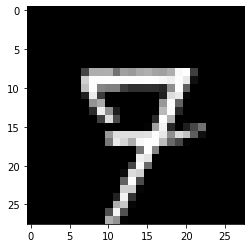

In [18]:
random_index = np.random.randint(100,inp_images.shape[0], 1)[0]
print(f"Index is : '{random_index}'")
inp_rnd_num_inf = np.random.randint(0,9,1)[0]
print(f"Input Number is : '{inp_rnd_num_inf}'")

inp_rnd_num_inf_ohe = create_one_hotencoding_inp(inp_rnd_num_inf).reshape(1,10)
inp_rnd_num_inf_ohe = torch.tensor(inp_rnd_num_inf_ohe).cuda()
print(f"Shape of my inp rand number : {inp_rnd_num_inf_ohe.shape}")
inp_img_inf = inp_images[random_index].reshape(1,1,28,28)
print(f"Shape of my input image : {inp_img_inf.shape}")

print("\n\n--------------------------------------------------------------------------------------------\n\n")

image = inp_img_inf.cpu().detach()
label = out_img_labels[random_index]
plt.imshow(image.squeeze(), cmap='gray')
print('Actual image label is :', label.cpu().detach().numpy())

pred_img_label, pred_sum_label = network(inp_img_inf, inp_rnd_num_inf_ohe.float())
print(f"Actual input random number is : {inp_rnd_num_inf}")
print(f"Predicted image label is : {pred_img_label.argmax().cpu().detach().numpy()}")
print(f"Predicted sum label is : {pred_sum_label.argmax().cpu().detach().numpy()}")

Index is : '10854'
Input Number is : '3'
Shape of my inp rand number : torch.Size([1, 10])
Shape of my input image : torch.Size([1, 1, 28, 28])


--------------------------------------------------------------------------------------------


Actual image label is : 4
Actual input random number is : 3
Predicted image label is : 4
Predicted sum label is : 7


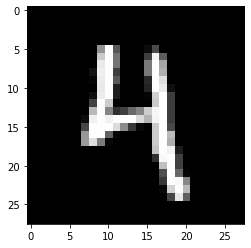

In [19]:
random_index = np.random.randint(100,inp_images.shape[0], 1)[0]
print(f"Index is : '{random_index}'")
inp_rnd_num_inf = np.random.randint(0,9,1)[0]
print(f"Input Number is : '{inp_rnd_num_inf}'")

inp_rnd_num_inf_ohe = create_one_hotencoding_inp(inp_rnd_num_inf).reshape(1,10)
inp_rnd_num_inf_ohe = torch.tensor(inp_rnd_num_inf_ohe).cuda()
print(f"Shape of my inp rand number : {inp_rnd_num_inf_ohe.shape}")
inp_img_inf = inp_images[random_index].reshape(1,1,28,28)
print(f"Shape of my input image : {inp_img_inf.shape}")

print("\n\n--------------------------------------------------------------------------------------------\n\n")

image = inp_img_inf.cpu().detach()
label = out_img_labels[random_index]
plt.imshow(image.squeeze(), cmap='gray')
print('Actual image label is :', label.cpu().detach().numpy())

pred_img_label, pred_sum_label = network(inp_img_inf, inp_rnd_num_inf_ohe.float())
print(f"Actual input random number is : {inp_rnd_num_inf}")
print(f"Predicted image label is : {pred_img_label.argmax().cpu().detach().numpy()}")
print(f"Predicted sum label is : {pred_sum_label.argmax().cpu().detach().numpy()}")

Index is : '15331'
Input Number is : '3'
Shape of my inp rand number : torch.Size([1, 10])
Shape of my input image : torch.Size([1, 1, 28, 28])


--------------------------------------------------------------------------------------------


Actual image label is : 7
Actual input random number is : 3
Predicted image label is : 7
Predicted sum label is : 10


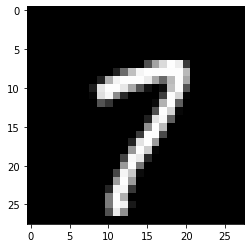

In [20]:
random_index = np.random.randint(100,inp_images.shape[0], 1)[0]
print(f"Index is : '{random_index}'")
inp_rnd_num_inf = np.random.randint(0,9,1)[0]
print(f"Input Number is : '{inp_rnd_num_inf}'")

inp_rnd_num_inf_ohe = create_one_hotencoding_inp(inp_rnd_num_inf).reshape(1,10)
inp_rnd_num_inf_ohe = torch.tensor(inp_rnd_num_inf_ohe).cuda()
print(f"Shape of my inp rand number : {inp_rnd_num_inf_ohe.shape}")
inp_img_inf = inp_images[random_index].reshape(1,1,28,28)
print(f"Shape of my input image : {inp_img_inf.shape}")

print("\n\n--------------------------------------------------------------------------------------------\n\n")

image = inp_img_inf.cpu().detach()
label = out_img_labels[random_index]
plt.imshow(image.squeeze(), cmap='gray')
print('Actual image label is :', label.cpu().detach().numpy())

pred_img_label, pred_sum_label = network(inp_img_inf, inp_rnd_num_inf_ohe.float())
print(f"Actual input random number is : {inp_rnd_num_inf}")
print(f"Predicted image label is : {pred_img_label.argmax().cpu().detach().numpy()}")
print(f"Predicted sum label is : {pred_sum_label.argmax().cpu().detach().numpy()}")